# Estimators

We provide here an example of scikit-dimension estimators performances on two different proteins, [villin](#villin) and [NTL9](#ntl9).

The test is performed on dihedral angles and data is divided between folded and unfolded trajectories.

## Villin

In [1]:
%run maintainer/sett.py #import packages and plot setup
Path("../extra").mkdir(exist_ok=True)

Settings loaded.


In [2]:
data = []
states = ['u0','u1', 'u2', 'f0', 'f1', 'f2'] 
estimators = ['CorrInt', 'DANCo', 'ESS', 'FisherS','KNN', 'lPCA', 'MADA', 'MiND_ML', 'MLE', 'MOM', 'TLE', 'TwoNN']
projection_method = 'Dihedrals'  # or 'Distances'
projection_kwargs = {'skip': 3}

for estimator, state in product(estimators, states):
    if estimator == 'MiND_ML': 
         mean_all, mean_last= intrinsic_dimension(topology='examples/villin/2f4k.pdb', 
                                                  trajectory=f'examples/villin/2f4k_{state}.xtc', 
                                                  projection_method=projection_method, 
                                                  projection_kwargs = projection_kwargs,
                                                  id_method='global',
                                                  id_kwargs={'estimator': estimator, 'D': 100}, #we changed default parameters to make it work on MD
                                                  verbose=True
                                                  )
    else:    
         mean_all, mean_last= intrinsic_dimension(topology='examples/villin/2f4k.pdb', 
                                                  trajectory=f'examples/villin/2f4k_{state}.xtc', 
                                                  projection_method=projection_method, 
                                                  projection_kwargs = projection_kwargs,
                                                  id_method='global',
                                                  id_kwargs={'estimator': estimator}, 
                                                  verbose=False
                                                  )

    data.append({'trajectory': state,
	  'estimator': estimator,
	  'mean_all': mean_all,
	  'mean_last': mean_last,
      })
data = pd.DataFrame(data)
data["folded"] = data["trajectory"].str.startswith("f")

md_intrinsic_dimension.md_intrinsic_dimension - INFO - Built-in projection "Dihedrals" computed.


md_intrinsic_dimension.md_intrinsic_dimension - INFO - Computing global intrinsic dimension using estimator "MiND_ML" (last simulation section = 100 frames).


md_intrinsic_dimension.md_intrinsic_dimension - INFO - Built-in projection "Dihedrals" computed.


md_intrinsic_dimension.md_intrinsic_dimension - INFO - Computing global intrinsic dimension using estimator "MiND_ML" (last simulation section = 100 frames).


md_intrinsic_dimension.md_intrinsic_dimension - INFO - Built-in projection "Dihedrals" computed.


md_intrinsic_dimension.md_intrinsic_dimension - INFO - Computing global intrinsic dimension using estimator "MiND_ML" (last simulation section = 100 frames).


md_intrinsic_dimension.md_intrinsic_dimension - INFO - Built-in projection "Dihedrals" computed.


md_intrinsic_dimension.md_intrinsic_dimension - INFO - Computing global intrinsic dimension using estimator "MiND_ML" (last simulation section = 100 frames).


md_intrinsic_dimension.md_intrinsic_dimension - INFO - Built-in projection "Dihedrals" computed.


md_intrinsic_dimension.md_intrinsic_dimension - INFO - Computing global intrinsic dimension using estimator "MiND_ML" (last simulation section = 100 frames).


md_intrinsic_dimension.md_intrinsic_dimension - INFO - Built-in projection "Dihedrals" computed.


md_intrinsic_dimension.md_intrinsic_dimension - INFO - Computing global intrinsic dimension using estimator "MiND_ML" (last simulation section = 100 frames).


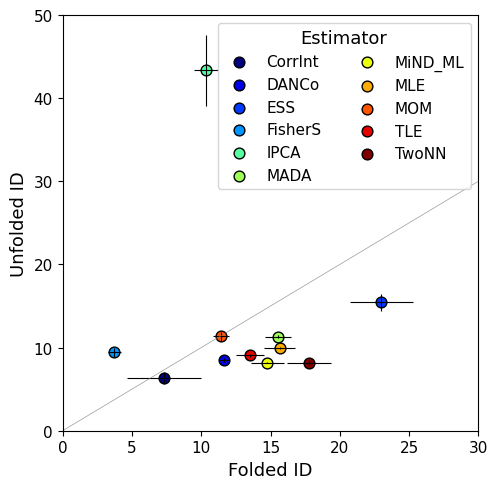

In [3]:
fig, ax =plt.subplots(figsize=(6,5))
ax = plt.gca()
group=data.groupby('trajectory')
estimators = data['estimator'].unique()

for i, estimator in enumerate(estimators):
    if estimator == "KNN": 
        continue

    color = cmap(i / (len(estimators) - 1)) 
    estimator_data = data[data['estimator'] == estimator]
    folded_values = estimator_data[estimator_data['folded']]['mean_all'].dropna()
    unfolded_values = estimator_data[~estimator_data['folded']]['mean_all'].dropna()
    x_mean = folded_values.mean()
    y_mean = unfolded_values.mean()
    x_std = folded_values.std(ddof=1) / np.sqrt(len(folded_values))
    y_std = unfolded_values.std(ddof=1) / np.sqrt(len(unfolded_values))

    ax.errorbar(x_mean, y_mean, xerr=x_std, yerr=y_std, fmt='none', ecolor='black', elinewidth=0.8,)
    ax.scatter(x_mean, y_mean,facecolors=color, edgecolors='black',s=60, label=estimator)

ax.set_box_aspect(1)    
min_val = data['mean_all'].min() - 0.5
max_val = data['mean_all'].max() + 0.5

plt.axline((5, 5), (12, 12), lw=0.5, color='grey', alpha=0.8)
plt.xlabel('Folded ID')
plt.ylabel('Unfolded ID')
plt.legend( loc='upper right', title= 'Estimator', ncol = 2)

plt.ylim(0, 50)
plt.xlim(0, 30)

plt.tight_layout()
plt.savefig(f'../extra/villin_estimators_fvsu_{projection_method}.pdf', dpi=300, bbox_inches='tight')
plt.show()


Because of the huge gap between folded replicas, in the previous plot we omitted KNN, which is shown below instead.

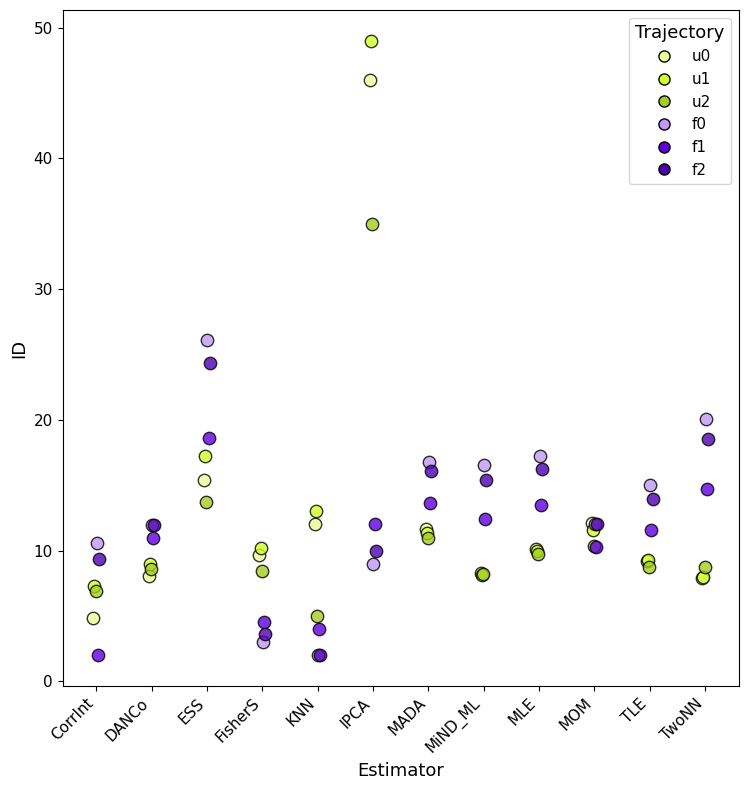

In [4]:

estimators = data["estimator"].unique()
states = data["trajectory"].unique()

fig, ax = plt.subplots(figsize=(8,8))

color_map = {state: colors(i % colors.N) for i, state in enumerate(states)}

shift_amount = 0.05
n_traj = len(states)
shifts = np.linspace(-shift_amount, shift_amount, n_traj)
shift_map = dict(zip(states, shifts))

for _, row in data.iterrows():
    est_idx = np.where(estimators == row["estimator"])[0][0]

    x = est_idx + shift_map[row["trajectory"]]

    mean_val = row["mean_all"]
    this_color = color_map[row["trajectory"]]

    ax.scatter(
        x, mean_val,
        color=this_color,
        edgecolor="black",
        alpha=0.8,
        s=80,
    )
ax.set_box_aspect(1)

ax.set_xticks(range(len(estimators)))
ax.set_xticklabels(estimators, rotation=45, ha="right")
ax.set_ylabel("ID")
ax.set_xlabel("Estimator")

handles = [
    plt.Line2D([0],[0], marker='o', color='w',
               markerfacecolor=color_map[s], markeredgecolor='black',
               markersize=8, label=s)
    for s in states
]
ax.legend(handles=handles, title='Trajectory', loc='best')

plt.tight_layout()
plt.savefig(f'../extra/villin_estimators_{projection_method}.pdf', dpi=300)
plt.show()


## NTL9

In [5]:
data2 = []
states = ['u0','u1', 'u2', 'f0', 'f1', 'f2'] 
estimators = ['CorrInt', 'DANCo', 'ESS', 'FisherS','KNN', 'lPCA', 'MADA', 'MiND_ML', 'MLE', 'MOM', 'TLE', 'TwoNN']
projection_method = 'Dihedrals'  # or 'Distances'
projection_kwargs = {'skip': 3}


for estimator, state in product(estimators, states):
    if estimator == 'MiND_ML':
         mean_all, mean_last = intrinsic_dimension(topology='examples/NTL9/ntl9.pdb', 
                                                   trajectory=f'examples/NTL9/ntl9_{state}.xtc', 
                                                   projection_method=projection_method, 
                                                   projection_kwargs = projection_kwargs,
                                                   id_method='global',
                                                   id_kwargs={'estimator': estimator, 'D': 100}, #we set non-defaults parameters to make it work with MD
                                                   verbose=True
                                                   )
    else:    
         mean_all, mean_last = intrinsic_dimension(topology='examples/NTL9/ntl9.pdb',
                                                    trajectory=f'examples/NTL9/ntl9_{state}.xtc', 
                                                    projection_method=projection_method, 
                                                    projection_kwargs = projection_kwargs,
                                                    id_method='global',
                                                    id_kwargs={'estimator': estimator}, 
                                                    verbose=False
                                                    )

    data2.append({'trajectory': state,
	  'estimator': estimator,
	  'mean_all': mean_all,
	  'mean_last': mean_last,
     })
data2 = pd.DataFrame(data2)
data2["folded"] = data2["trajectory"].str.startswith("f")


md_intrinsic_dimension.md_intrinsic_dimension - INFO - Built-in projection "Dihedrals" computed.


md_intrinsic_dimension.md_intrinsic_dimension - INFO - Computing global intrinsic dimension using estimator "MiND_ML" (last simulation section = 100 frames).


md_intrinsic_dimension.md_intrinsic_dimension - INFO - Built-in projection "Dihedrals" computed.


md_intrinsic_dimension.md_intrinsic_dimension - INFO - Computing global intrinsic dimension using estimator "MiND_ML" (last simulation section = 100 frames).


md_intrinsic_dimension.md_intrinsic_dimension - INFO - Built-in projection "Dihedrals" computed.


md_intrinsic_dimension.md_intrinsic_dimension - INFO - Computing global intrinsic dimension using estimator "MiND_ML" (last simulation section = 100 frames).


md_intrinsic_dimension.md_intrinsic_dimension - INFO - Built-in projection "Dihedrals" computed.


md_intrinsic_dimension.md_intrinsic_dimension - INFO - Computing global intrinsic dimension using estimator "MiND_ML" (last simulation section = 100 frames).


md_intrinsic_dimension.md_intrinsic_dimension - INFO - Built-in projection "Dihedrals" computed.


md_intrinsic_dimension.md_intrinsic_dimension - INFO - Computing global intrinsic dimension using estimator "MiND_ML" (last simulation section = 100 frames).


md_intrinsic_dimension.md_intrinsic_dimension - INFO - Built-in projection "Dihedrals" computed.


md_intrinsic_dimension.md_intrinsic_dimension - INFO - Computing global intrinsic dimension using estimator "MiND_ML" (last simulation section = 100 frames).


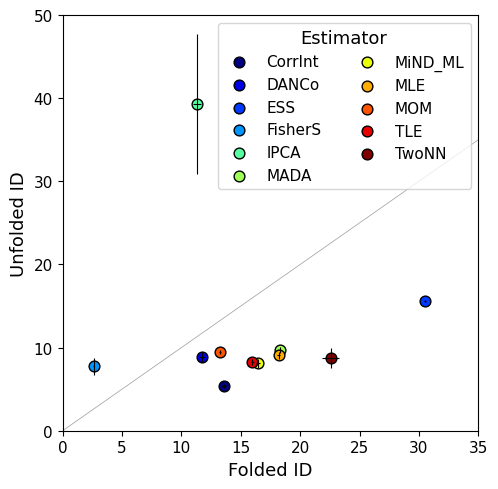

In [6]:

fig, ax = plt.subplots(figsize=(6,5))
ax = plt.gca()
group=data2.groupby('trajectory')
estimators = data2['estimator'].unique()

for i, estimator in enumerate(estimators):
    if estimator == "KNN": 
        continue

    color = cmap(i / (len(estimators) - 1)) 
    estimator_data2 = data2[data2['estimator'] == estimator]
    folded_values = estimator_data2[estimator_data2['folded']]['mean_all'].dropna()
    unfolded_values = estimator_data2[~estimator_data2['folded']]['mean_all'].dropna()
    x_mean = folded_values.mean()
    y_mean = unfolded_values.mean()
    x_std = folded_values.std(ddof=1) / np.sqrt(len(folded_values))
    y_std = unfolded_values.std(ddof=1) / np.sqrt(len(unfolded_values))

    ax.errorbar(x_mean, y_mean, xerr=x_std, yerr=y_std, fmt='none', ecolor='black', elinewidth=0.8,)
    ax.scatter(x_mean, y_mean,facecolors=color, edgecolors='black',s=60, label=estimator)

min_val = data2['mean_all'].min() - 0.5
max_val = data2['mean_all'].max() + 0.5
ax.set_box_aspect(1)

plt.axline((5, 5), (12, 12), lw=0.5, color='grey', alpha=0.8)
plt.xlabel('Folded ID')
plt.ylabel('Unfolded ID')
plt.legend( loc='upper right', title= 'Estimator', ncol = 2)

plt.ylim(0, 50)
plt.xlim(0, 35)

plt.tight_layout()
plt.savefig(f'../extra/ntl9_estimators_fvsu_{projection_method}.pdf', dpi=300, bbox_inches='tight')
plt.show()


Because of the huge gap between folded replicas, in the previous plot we omitted KNN, which is shown below instead. 

As the result obtained on the two proteins is similar, we suggest not to use KNN for this kind of study.

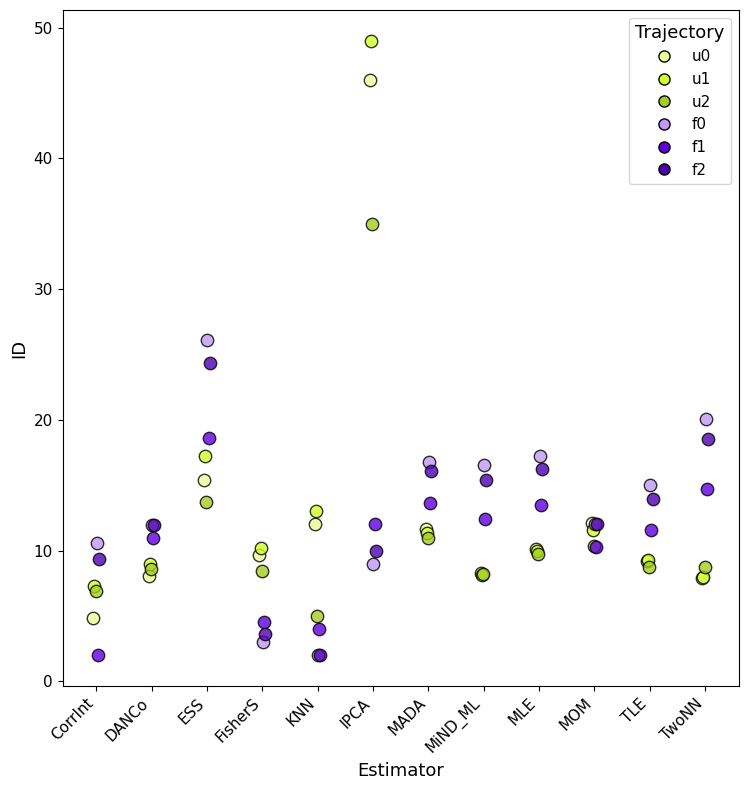

In [7]:
   
estimators = data2["estimator"].unique()
states = data2["trajectory"].unique()

fig, ax = plt.subplots(figsize=(8,8))
color_map = {state: colors(i % colors.N) for i, state in enumerate(states)}
shift_amount = 0.05
n_traj = len(states)
shifts = np.linspace(-shift_amount, shift_amount, n_traj)
shift_map = dict(zip(states, shifts))

for _, row in data.iterrows():
    est_idx = np.where(estimators == row["estimator"])[0][0]
    x = est_idx + shift_map[row["trajectory"]]
    mean_val = row["mean_all"]
    this_color = color_map[row["trajectory"]]
    ax.scatter(
        x, mean_val,
        color=this_color,
        edgecolor="black",
        alpha=0.8,
        s=80,
    )
ax.set_box_aspect(1)

ax.set_xticks(range(len(estimators)))
ax.set_xticklabels(estimators, rotation=45, ha="right")
ax.set_ylabel("ID")
ax.set_xlabel("Estimator")

handles = [
    plt.Line2D([0],[0], marker='o', color='w',
               markerfacecolor=color_map[s], markeredgecolor='black',
               markersize=8, label=s)
    for s in states
]
ax.legend(handles=handles, title='Trajectory', loc='best')
plt.tight_layout()
plt.savefig(f'../extra/ntl9_estimators_{projection_method}.pdf', dpi=300)
plt.show()
